In [1]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Import libraries

In [2]:
# Modules
import math
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Autoregressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Hyperparameter Grid search
from skforecast.model_selection import grid_search_forecaster

# Backtesting
from skforecast.model_selection import backtesting_forecaster

# Models
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

import plotly.io as pio

In [3]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [11]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
country = 'FIN'

# Dependant variable (TIV or Orders)
dep_var = 'Orders'

# Metrics
metrics = pd.DataFrame()

steps = 24  # Number of months of testing

### Load Data

In [35]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index
df = df.set_index("Date")
df.index = pd.PeriodIndex(df.index, freq="M")

# Feature engineering - Seasonal patterns
df['Quarter'] = pd.PeriodIndex(df.index, freq='Q').quarter

# Load files into a pandas dataframes
file = path + 'target.xlsx'
df_nordics = pd.read_excel(file, sheet_name=dep_var)

# Set index
df_nordics = df_nordics.set_index("Date")
df_nordics.index = pd.PeriodIndex(df_nordics.index, freq="M")

#Merge dataframes
df = pd.merge(df, df_nordics[df_nordics.columns.difference([country])], left_index=True, right_index=True)

df.index = df.index.to_timestamp()

# Split data
train = df[:-steps]
test  = df[-steps:]

# Select input and target variables
X_train = train.drop(dep_var, axis=1)
y_train = train[dep_var]

X_test = test.drop(dep_var, axis=1)
y_test = test[dep_var]

start=len(train)
end=len(train)+len(test)-1

print(f"Dataset length : (n={len(df)})")
print('\nData shape:', train.shape, test.shape)
print('\nTrain shape:', X_train.shape, y_train.shape)
print('\nTest shape:', X_test.shape, y_test.shape)
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Dataset length : (n=204)

Data shape: (180, 9) (24, 9)

Train shape: (180, 8) (180,)

Test shape: (24, 8) (24,)
Train dates    : 2006-01-01 00:00:00 --- 2020-12-01 00:00:00  (n=180)
Test dates     : 2021-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=24)


In [39]:
df

,Orders,CPI,UR,LTIR,TIV,Quarter,DEN,NOR,SWE
Date,,,,,,,,,
2006-01-01,1124,0.807265,8.3,3.280000,20178,1,161,233,110
2006-02-01,1079,0.901804,8.0,3.440000,12846,1,250,270,303
2006-03-01,1210,0.899101,7.7,3.620000,15165,1,468,406,634
2006-04-01,1147,1.297405,7.7,3.880000,13474,2,412,356,1097
2006-05-01,1001,1.701702,7.9,3.940000,16516,2,550,553,926
...,...,...,...,...,...,...,...,...,...
2022-08-01,254,7.616082,7.2,1.624904,8055,3,343,347,744
2022-09-01,228,8.119296,7.3,2.420836,7779,3,337,295,666
2022-10-01,188,8.310766,6.4,2.894486,7026,4,322,413,711


In [40]:
# Define exogenous variables
df_exo = df[df.columns.difference([dep_var])]
#train_exo = train[train.columns.difference([dep_var])]
#test_exo = test[test.columns.difference([dep_var])]

print('\nData shape:', train.shape, test.shape)
#print('Exog shape:', train_exo.shape, test_exo.shape)


Data shape: (180, 9) (24, 9)
Exog shape: (180, 8) (24, 8)


### Backtesting

In [60]:
def backtest(model_name, forecaster):
    n_backtesting = 12*14   # Number of samples for backtest (14 y)
    metric, backtest_pred = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df[dep_var],
                                    exog               = df_exo,
                                    initial_train_size = len(df) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = 6,
                                    refit              = True,
                                    metric             = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
                                    verbose            = False
                                 )
         
    # Calculate metrics
    mae = metric[1]                                                     # MAE (Mean Absolute Error)
    #mse = metric[0]                                                    # MSE (Mean Squared Error)
    rmse = math.sqrt(metric[0])                                         # RMSE (Root Mean Squared Error)    
    mape = metric[2] * 100                                              # MAPE
    accuracy = 100 - mape                                               # Accuracy
    
    # Print metrics
    print(model_name, 'Backtesting:')                                   # Model name
    print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE    
    print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE      
    print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
    print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, rmse, mape, accuracy]
    metrics.index = ['MAE', 'RMSE', 'MAPE', 'Accuracy']   
    
    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(dict(x=backtest_pred.index, y=df[dep_var], mode='lines', name= 'Train')))
    fig.add_trace(go.Scatter(dict(x=backtest_pred.index, y=backtest_pred.pred, mode='lines', name= 'Predictions')))
    fig.update_layout(height=500, width=1200, title_text=model_name + " Backtesting in " + country)    
    fig.show()

Ada Backtesting:
Mean Absolute Error: 105.20.
Root Mean Squared Error: 134.66.
Mean Absolute Percentage Error: 24.21%.
Accuracy = 75.79%.


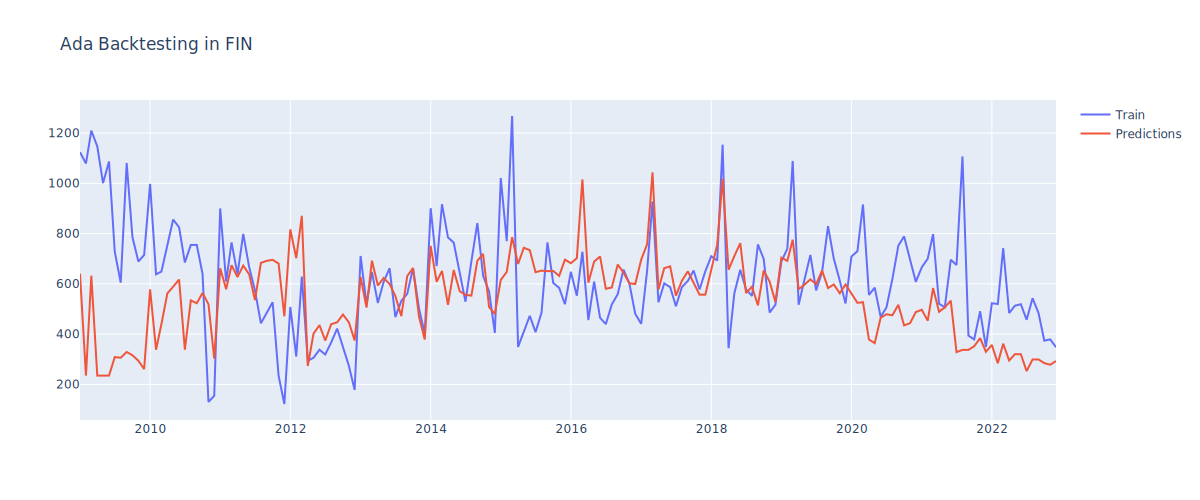

GB Backtesting:
Mean Absolute Error: 92.81.
Root Mean Squared Error: 126.03.
Mean Absolute Percentage Error: 19.94%.
Accuracy = 80.06%.


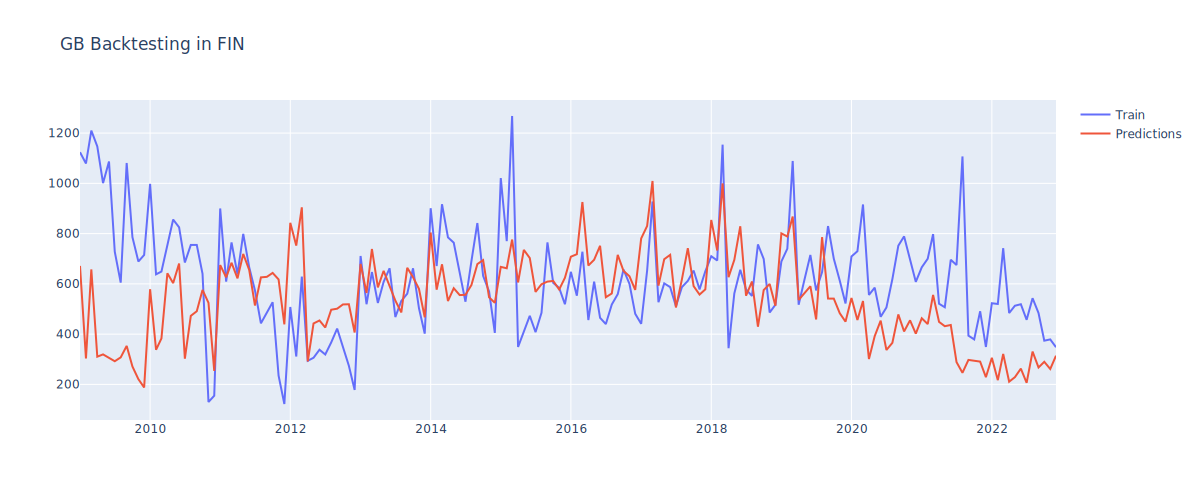

XGB Backtesting:
Mean Absolute Error: 101.62.
Root Mean Squared Error: 135.35.
Mean Absolute Percentage Error: 21.64%.
Accuracy = 78.36%.


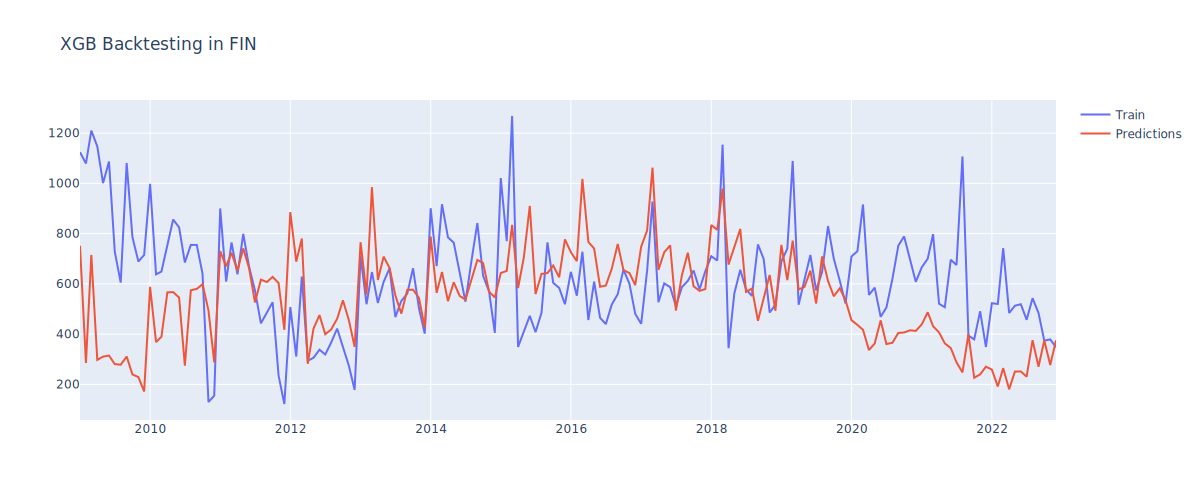

LGBM Backtesting:
Mean Absolute Error: 119.59.
Root Mean Squared Error: 151.88.
Mean Absolute Percentage Error: 27.19%.
Accuracy = 72.81%.


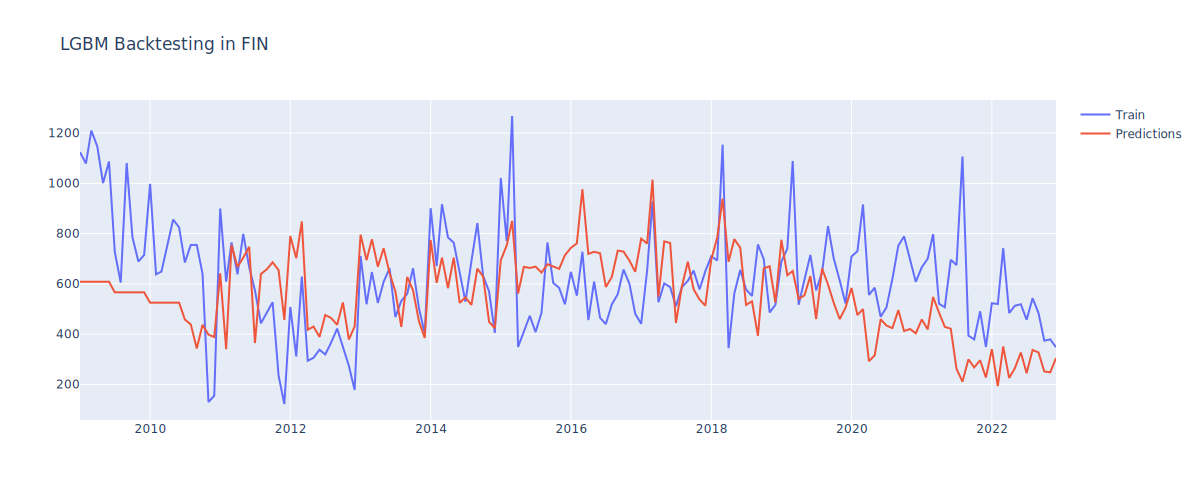

RF Backtesting:
Mean Absolute Error: 103.13.
Root Mean Squared Error: 134.89.
Mean Absolute Percentage Error: 23.33%.
Accuracy = 76.67%.


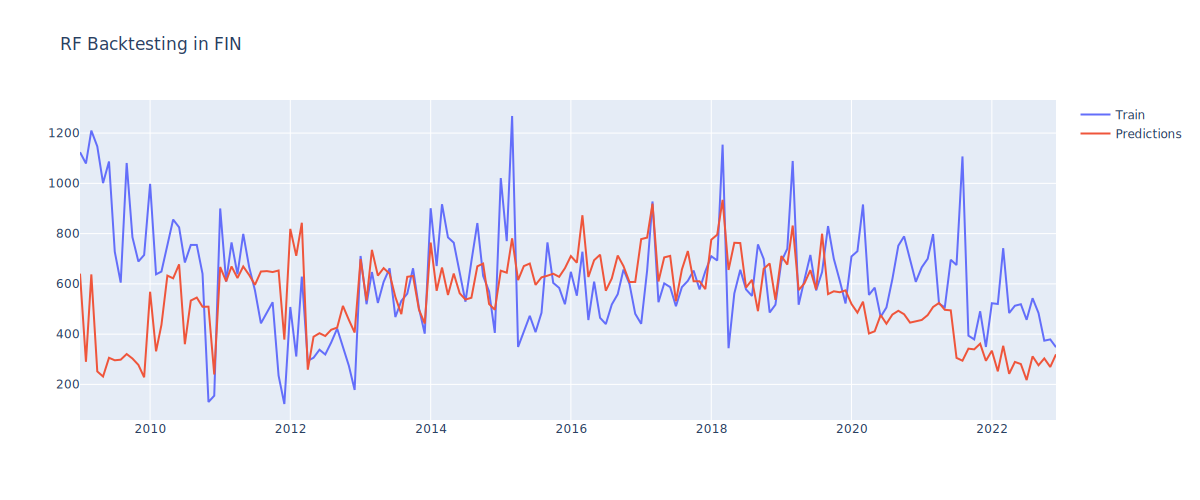

ET Backtesting:
Mean Absolute Error: 103.19.
Root Mean Squared Error: 134.02.
Mean Absolute Percentage Error: 24.00%.
Accuracy = 76.00%.


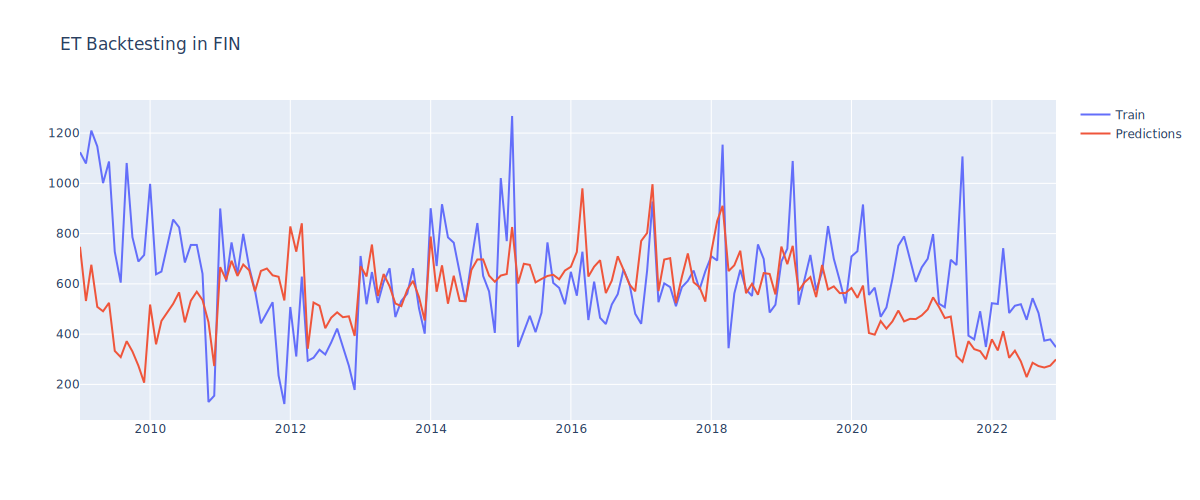

In [61]:
# Models
modelclasses = [
    ["Ada", AdaBoostRegressor],
    ["GB", GradientBoostingRegressor],    
    ["XGB", XGBRegressor],
    ["LGBM", LGBMRegressor],    
    ["RF", RandomForestRegressor],
    ["ET", ExtraTreesRegressor],
]

number_of_lags = 12   # Number of lags 

for model_name, Model in modelclasses:
    
    # Create forecaster
    forecaster = ForecasterAutoreg(
            regressor = Model(),
            lags = number_of_lags
    )
    
    # Backtest
    backtest(model_name, forecaster)

In [50]:
def plot_metrics(m, w, h, error: bool):

    chart = m.transpose()
    if error:
        chart.drop(['Accuracy'], axis=1, inplace=True)
    else:
        chart.drop(['MAE', 'RMSE', 
                    'MAPE'], axis=1, inplace=True)
    ax = chart.plot.bar(title="Models Performance (" + country + ' /  ' 
            + dep_var + ')',
            figsize=(w, h))        
    for c in ax.containers:        
        ax.bar_label(c, fmt='%0.2f', label_type='edge', padding=5)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

### Summary

In [51]:
metrics

,Ada,GB,XGB,LGBM,RF,ET
MAE,99.090032,90.376798,98.928434,106.441041,96.219226,89.056845
RMSE,127.798079,117.669268,134.162212,138.292749,125.624095,118.370613
MAPE,22.716949,19.480901,21.249472,23.904691,21.298497,19.796005
Accuracy,77.283051,80.519099,78.750528,76.095309,78.701503,80.203995


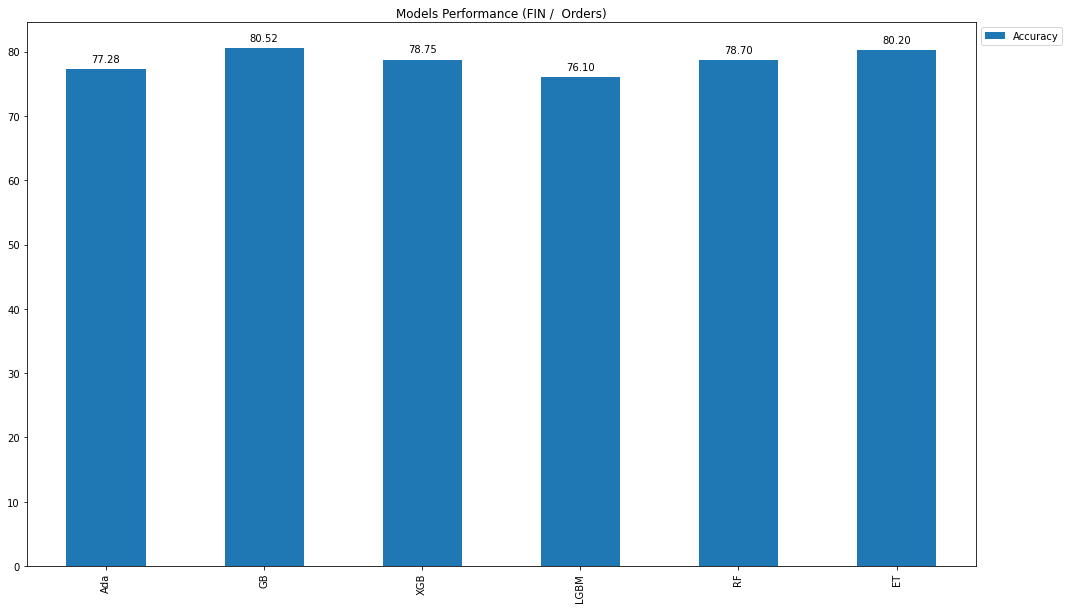

In [52]:
plot_metrics(metrics, 17, 10, False)

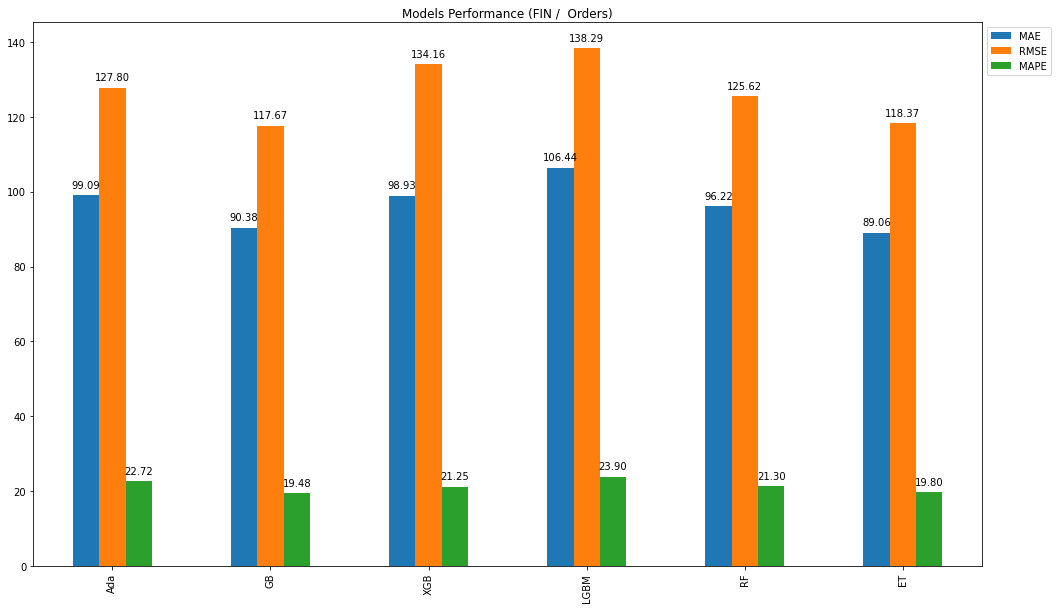

In [53]:
plot_metrics(metrics, 17, 10, True)